# Alex AI/ML Training V3

Testing approach from https://www.sciencedirect.com/science/article/pii/S0021929018304354
Estimation of vertical ground reaction force during running using neural network model and uniaxial accelerometer



In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scienceplots
plt.style.use(['science','no-latex','ieee', 'high-vis'])
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["DejaVu Serif"],  # specify font here
    "font.size":9})          # specify font size here

ModuleNotFoundError: No module named 'scienceplots'

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-02-11 12:44:58.311841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 12:44:58.342062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739270698.359400  965586 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739270698.364678  965586 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 12:44:58.383010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5135148094822443464
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 43115610112
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14099025822518834943
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1739270717.221090  965586 gpu_device.cc:2413] Ignoring visible gpu device (device: 1, name: Quadro K1200, pci bus id: 0000:2d:00.0, compute capability: 5.0) with core count: 4. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
I0000 00:00:1739270717.229996  965586 gpu_device.cc:2022] Created device /device:GPU:0 with 41118 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6


In [3]:
#directory path
dir_path = "/home/alexbeat/data/kuopio-gait-dataset-ml"
results_dir = "results"
input_path = f"{dir_path}/_main-input.csv"
output_path = f"{dir_path}/_main-output.csv"

In [4]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [24]:
x_og = pd.read_csv(input_path, index_col=0)  # 49 input features
y_og = pd.read_csv(output_path, index_col=0)   # 3 output features (x, y, z)

y_cols = ['f2_1','f2_2','f2_3','m2_1','m2_2','m2_3']
x_og.drop(columns=['time'], inplace=True)
y_og = y_og[y_cols]

KeyError: "['m2_1', 'm2_2', 'm2_3'] not in index"

In [6]:
# Assuming your data is sampled at 100 Hz
fs = 100  # Sampling frequency
cutoff = 6  # Cutoff frequency for the lowpass filter

x_filtered=x_og
# x_filtered = pd.DataFrame()
# # Apply the filter to each column in x
# for column in x_og.columns:
#     x_filtered[column] = lowpass_filter(x_og[column], cutoff, fs)

In [7]:
num_rows = 200000
x = x_filtered[:num_rows]
y = y_og[:num_rows]

In [8]:
print(x.head())

   pelvis_imu_acc_0  pelvis_imu_acc_1  pelvis_imu_acc_2  tibia_r_imu_acc_0  \
0          9.761505         -0.539103          1.818704          12.697140   
1         10.134969         -0.911804          1.594711          10.897347   
2         10.385214         -1.351347          1.155096           9.525765   
3         10.543116         -1.864298          0.684864           9.072569   
4         10.660259         -2.339200          0.291542           9.549234   

   tibia_r_imu_acc_1  tibia_r_imu_acc_2  femur_r_imu_acc_0  femur_r_imu_acc_1  \
0          16.125368           6.755737           6.553590          -9.642062   
1          16.414892           6.965524           7.794528          -8.131455   
2          14.627335           5.945245           8.543280          -7.183258   
3          11.909804           4.448972           8.545444          -6.877351   
4          10.364927           3.148921           7.764376          -6.626254   

   femur_r_imu_acc_2  tibia_l_imu_acc_0  ...

In [9]:
print(y_og.head())
print(y.head())

       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854
       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854


In [10]:
scalerX = StandardScaler()
X = scalerX.fit_transform(x)

Y = y
# scalerY = StandardScaler()
# Y = scalerY.fit_transform(y)
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (200000, 49)
Y shape: (200000, 3)


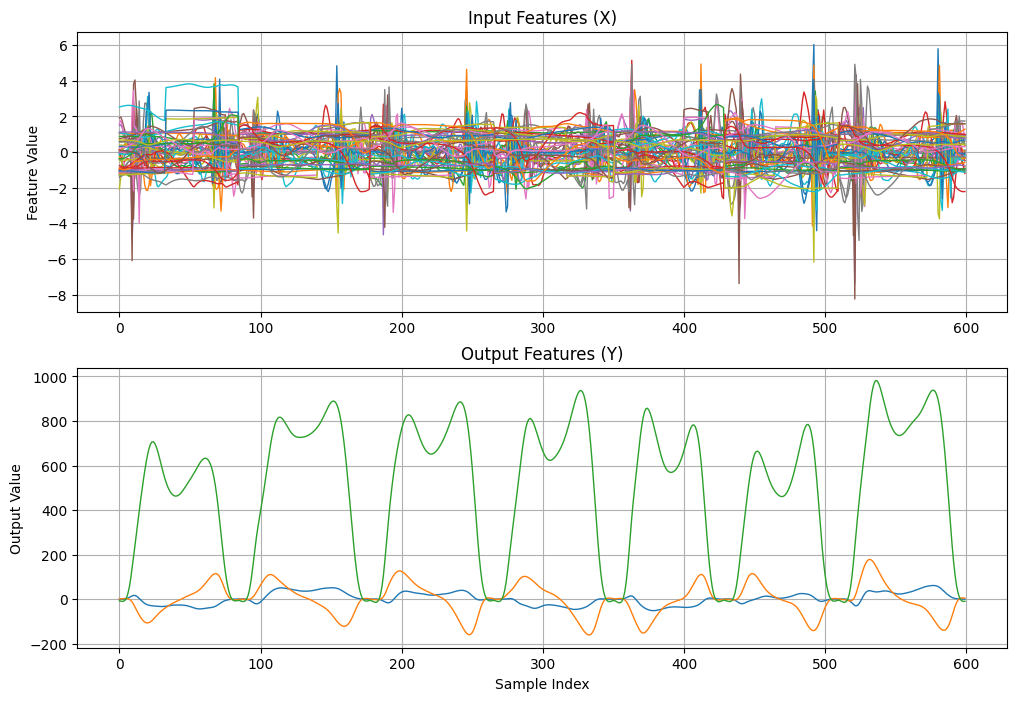

In [11]:
# Create a figure
plt.figure(figsize=(12, 8))

graph_window = 600
# Plotting the input features (X)
plt.subplot(2, 1, 1)
for i in range(X.shape[1]):  # Loop through each feature (column)
    plt.plot(X[:graph_window, i], label=f'Feature {i+1}', linewidth=1)
plt.title('Input Features (X)')
# plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

# Plotting the output features (y)
plt.subplot(2, 1, 2)
for i in range(Y.shape[1]):  # Loop through each output feature (column)
    plt.plot(Y.iloc[:graph_window, i], label=f'Output {i+1}', linewidth=1)
plt.title('Output Features (Y)')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

plt.savefig(os.path.join(results_dir,f'input_output_features_{graph_window}.eps'), format='eps')  # Save as EPS
plt.show()

In [12]:
model = Sequential()

model.add(Input(shape=(49,)))  # Using Input layer

# Input layer and first hidden layer
model.add(Dense(256, activation='sigmoid'))

# Second hidden layer
model.add(Dense(512, activation='relu'))

# Input layer and first hidden layer
model.add(Dense(128, activation='sigmoid'))

# Output layer
model.add(Dense(3, activation='linear'))  # Linear activation for regression

I0000 00:00:1739270721.144437  965586 gpu_device.cc:2413] Ignoring visible gpu device (device: 1, name: Quadro K1200, pci bus id: 0000:2d:00.0, compute capability: 5.0) with core count: 4. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
I0000 00:00:1739270721.145594  965586 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41118 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,435 (822.01 KB)

 Trainable params: 210,435 (822.01 KB)

 Non-trainable params: 0 (0.00 B)

None


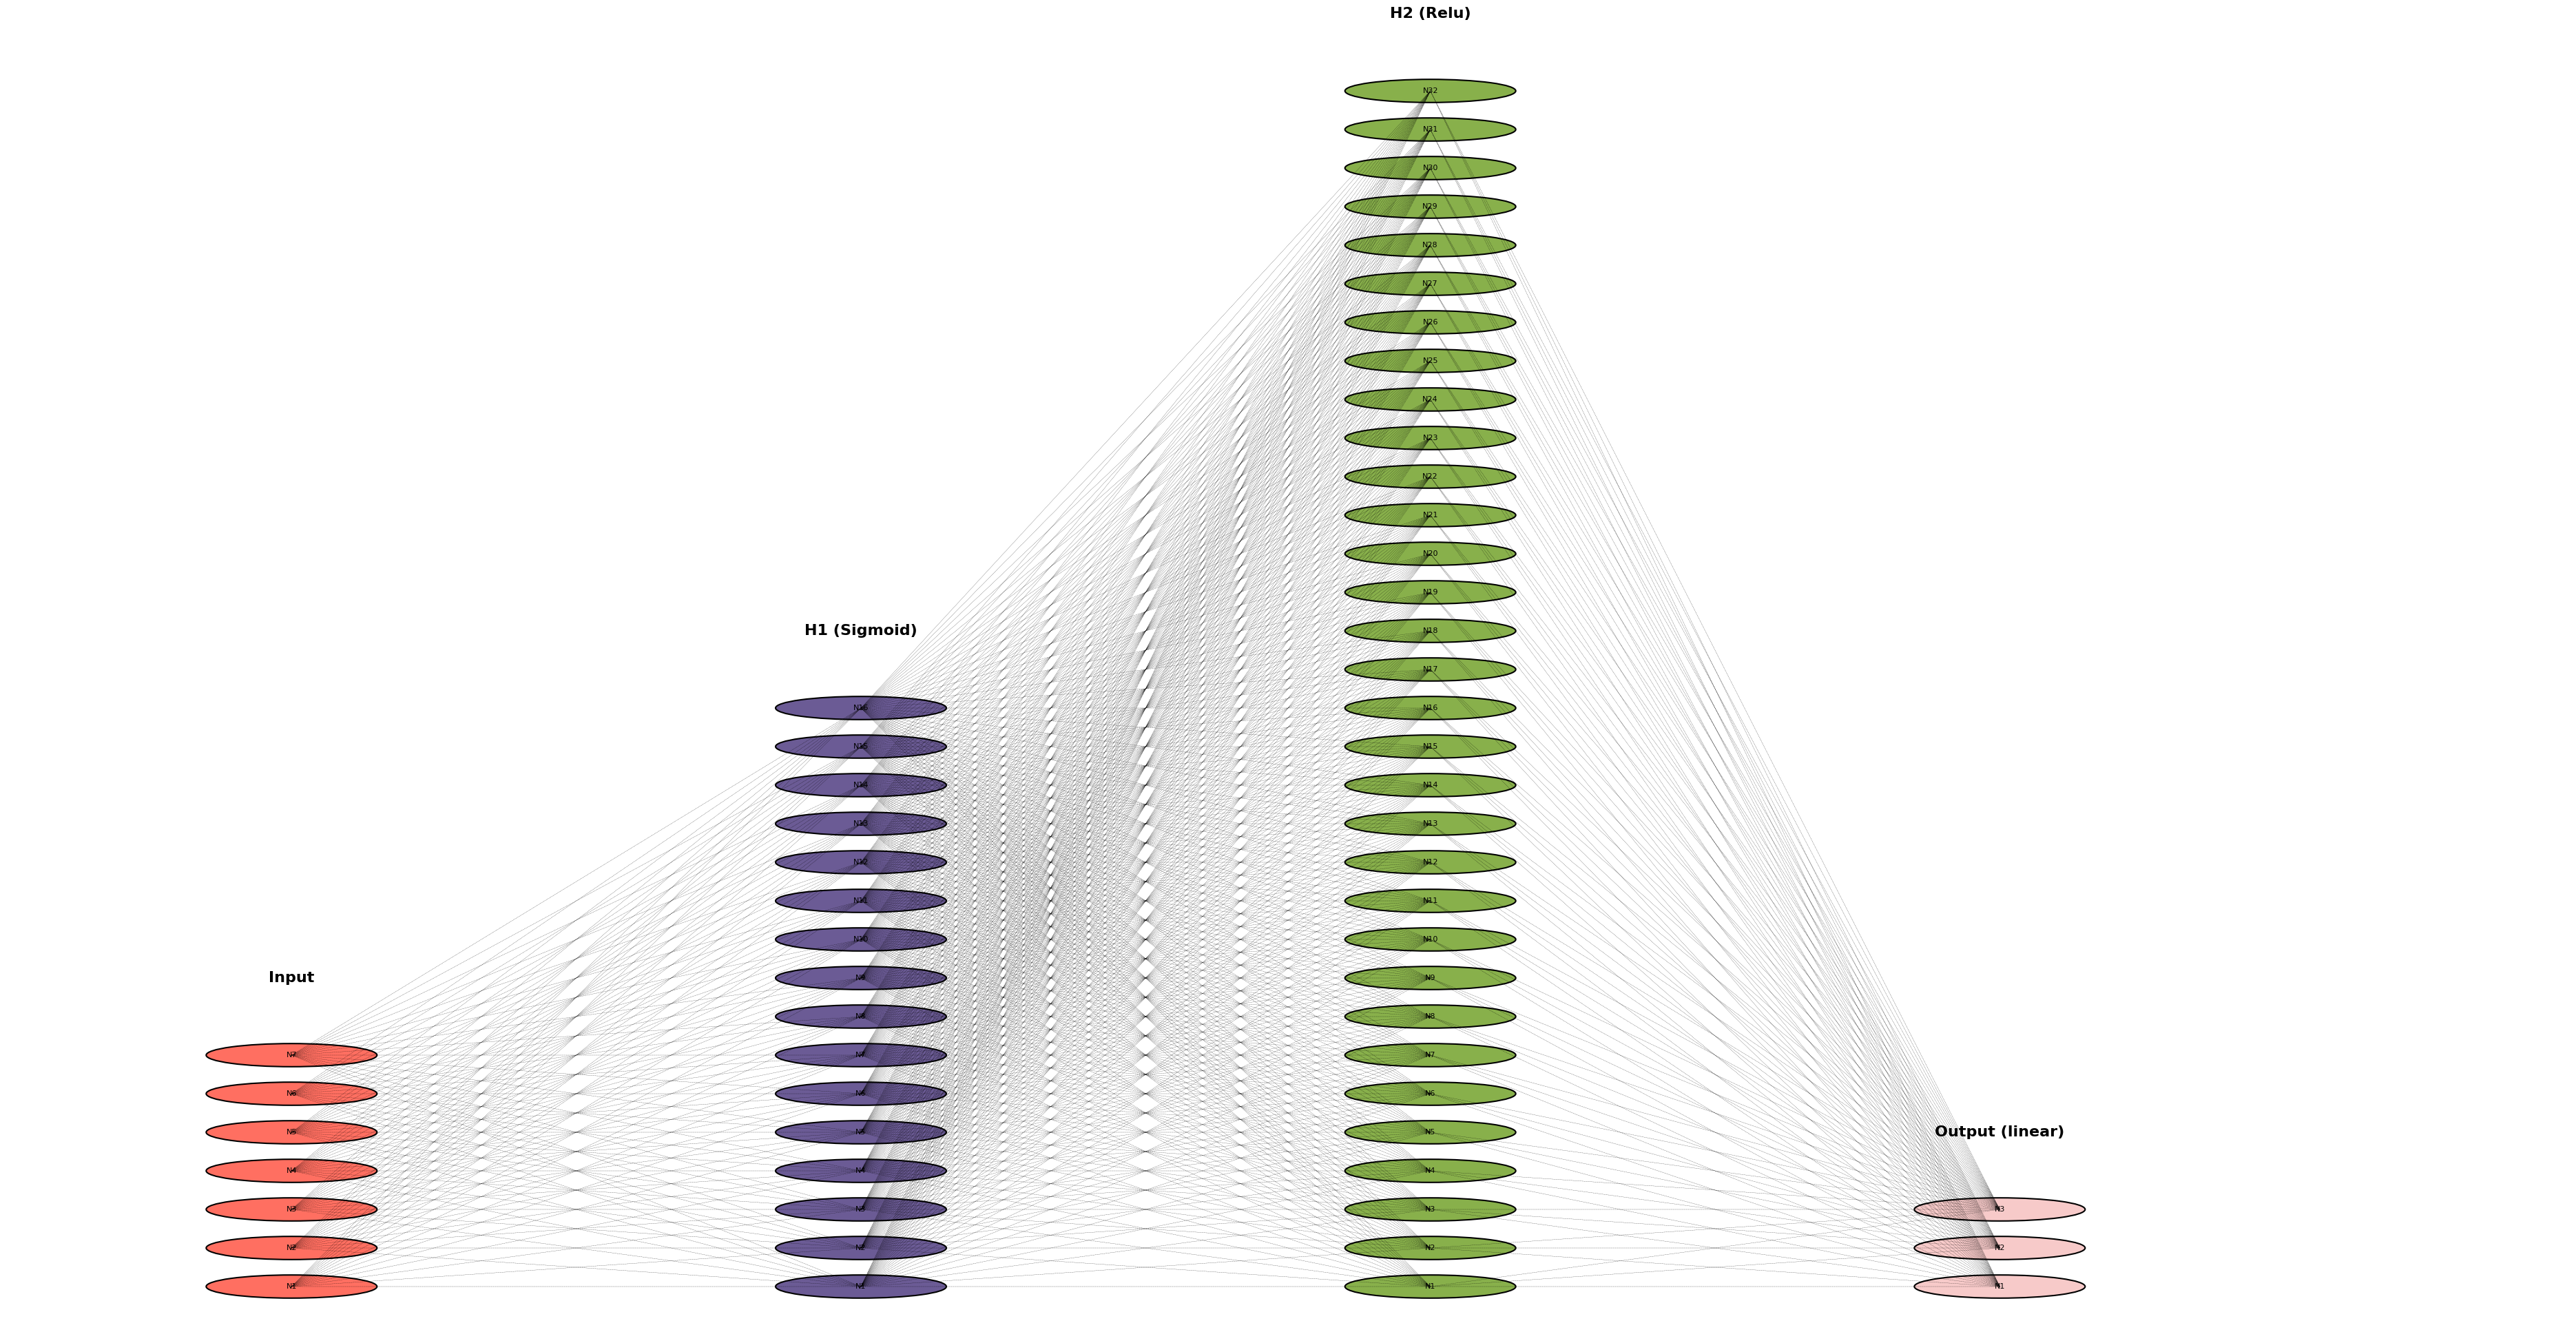

In [14]:
def draw_neural_net(ax, layer_sizes, layer_names):
    # Define vibrant colors for different layers
    colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']  # Brighter colors
    
    # Loop through each layer
    for n, (layer_size, color, layer_name) in enumerate(zip(layer_sizes, colors, layer_names)):
        # Calculate the x position for the layer
        x = n * 2  # Spacing between layers
        
        # Calculate the y positions for the neurons in this layer
        y = np.linspace(1, layer_size, layer_size)
        
        # Draw the neurons
        for i in range(layer_size):
            circle = plt.Circle((x, y[i]), 0.3, color=color, ec='black', lw=1.5)
            ax.add_artist(circle)
            # Add the neuron label
            ax.text(x, y[i], f'N{i+1}', horizontalalignment='center', verticalalignment='center', fontsize=8)

        # Add the activation function header
        ax.text(x, layer_size + 2, f'{layer_name}', 
                horizontalalignment='center', verticalalignment='center', fontsize=16, fontweight='bold')

        # Draw connections to the next layer
        if n < len(layer_sizes) - 1:
            next_layer_size = layer_sizes[n + 1]
            for i in range(layer_size):
                for j in range(next_layer_size):
                    ax.plot([x, x + 2], [y[i], np.linspace(1, next_layer_size, next_layer_size)[j]], 'k--', lw=0.2)

# Define the layer sizes and names
scale_down = 16
layer_sizes = [int(49/7), int(256/scale_down),int(512/scale_down), 3]  # Input layer, 1st hidden layer, 2nd hidden layer, output layer
layer_names = ['Input', 'H1 (Sigmoid)', 'H2 (Relu)', 'Output (linear)']


# Create the figure
fig, ax = plt.subplots(figsize=(48, 24))
ax.set_xlim(-1, len(layer_sizes) * 2)  # Set x limits
ax.set_ylim(0, max(layer_sizes) + 1)  # Set y limits
ax.axis('off')  # Turn off the axis

# Draw the neural network
draw_neural_net(ax, layer_sizes, layer_names)

# Add title
# plt.title('Keras Model Architecture', fontsize=16, fontweight='bold')
plt.savefig(os.path.join(results_dir,f'model_architecture_flow_chart.eps'), format='eps')  # Save as EPS
plt.show()

Model architecture diagram saved as 'model_architecture.png'


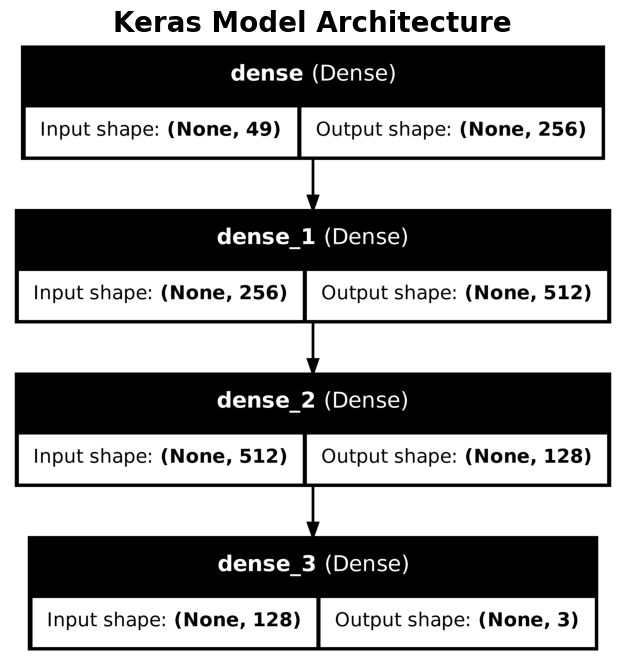

In [15]:
# Generate a diagram of the model architecture

arcitecture_image_path = os.path.join(results_dir,'model_architecture.png')
plot_model(model, to_file=arcitecture_image_path, show_shapes=True, show_layer_names=True, dpi=600)
print("Model architecture diagram saved as 'model_architecture.png'")
# Load and display the saved model architecture image

img = mpimg.imread(arcitecture_image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Keras Model Architecture', fontsize=20, fontweight='bold')
plt.show()

In [16]:
model.fit(X, Y, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50


I0000 00:00:1739270727.625280  966549 service.cc:148] XLA service 0x7a0a54005130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739270727.625322  966549 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-02-11 12:45:27.663388: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739270727.764347  966549 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-11 12:45:27.816488: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2025-02-11 12:45:30.36734

  35/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 117648.9844 - mae: 191.4817   

I0000 00:00:1739270732.015067  966549 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 103899.9141 - mae: 181.0364 - val_loss: 66538.3203 - val_mae: 152.0932
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 64141.7617 - mae: 151.0903 - val_loss: 44188.6992 - val_mae: 130.9886
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 44700.8633 - mae: 132.0416 - val_loss: 36541.9180 - val_mae: 118.5815
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 32414.8613 - mae: 109.4948 - val_loss: 15630.3213 - val_mae: 71.2937
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 14382.7031 - mae: 67.3264 - val_loss: 10075.0596 - val_mae: 51.3277
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 10067.7012 - mae: 50.4908 - val_loss: 8506.3516 - val_mae: 45.1256
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 8633.1777 - mae: 45.0301 - val_loss: 7278.8770 - val_mae: 41.2455
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7411.7266 - mae: 41.0334 -

In [17]:
x_text_path = f"{dir_path}/input/01-l_comf_01-input.csv"
y_text_path = f"{dir_path}/output/01-l_comf_01-output.csv"
X_test = pd.read_csv(x_text_path, index_col=0)  # 49 input features
y_test = pd.read_csv(y_text_path, index_col=0)   # 3 output features (x, y, z)
X_test.drop(columns=['time'], inplace=True)
y_test.drop(columns=['time'], inplace=True)

# for column in X_test.columns:
#     X_test[column] = lowpass_filter(X_test[column], cutoff, fs)

# Normalize test data
X_test = scalerX.transform(X_test)
# y_test = scalerY.transform(y_test)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 121652.8125 - mae: 200.2010
Test Loss: 97223.078125, Test MAE: 175.0768585205078


In [18]:
predictions = model.predict(X_test)
print(predictions)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step  
[[ 1.2166340e+01 -9.6363983e+00  7.0086108e+02]
 [ 1.2146135e+01 -9.3179426e+00  7.0223041e+02]
 [ 1.2128492e+01 -9.1183672e+00  7.0116772e+02]
 ...
 [-5.1092482e-01 -9.4555931e+00  6.0019720e+02]
 [-2.9686403e-01 -8.7202158e+00  5.9746478e+02]
 [-9.9641943e-01 -7.4255676e+00  6.0065887e+02]]


In [19]:
from OneEuroFilter import OneEuroFilter

def apply_one_euro_filter(nd_array, config):
    num_rows, num_cols = nd_array.shape
    filtered_array = np.zeros_like(nd_array)  # Create an array to hold filtered values
    f = OneEuroFilter(**config)
    # Define a helper function to filter a single column
    def filter_column(col_index):
        return np.array([f(nd_array[row, col_index], row) for row in range(num_rows)])

    # Apply the filter to each column using map
    filtered_array = np.column_stack(list(map(filter_column, range(num_cols))))

    return filtered_array

In [20]:
# Apply the One Euro Filter to all columns except 'time'
config = {
    'freq': 12,       # Hz
    'mincutoff': 0.001,  # Hz
    'beta': 1.0,       
    'dcutoff': 1.0  
    }
# freq = 12 # Frequency in Hz
# min_cutoff = 0.04
# beta = 0.7
# derivative_cutoff = 1.0
predictions_filtered = apply_one_euro_filter(predictions, config)

# Print the smoothed DataFrame
print(predictions_filtered)

[[ 1.2166340e+01 -9.4571886e+00  7.0067670e+02]
 [ 1.2165485e+01 -9.3382730e+00  7.0222748e+02]
 [ 1.2157423e+01 -9.2758884e+00  7.0118311e+02]
 ...
 [-6.5517318e-01 -9.6086912e+00  6.0004510e+02]
 [-4.0549415e-01 -8.8586226e+00  5.9765344e+02]
 [-8.4469271e-01 -7.5761404e+00  6.0046570e+02]]


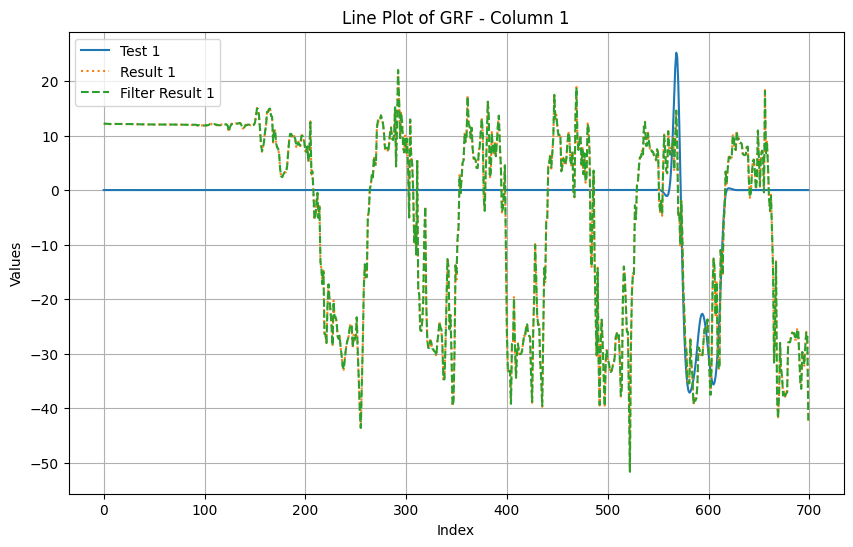

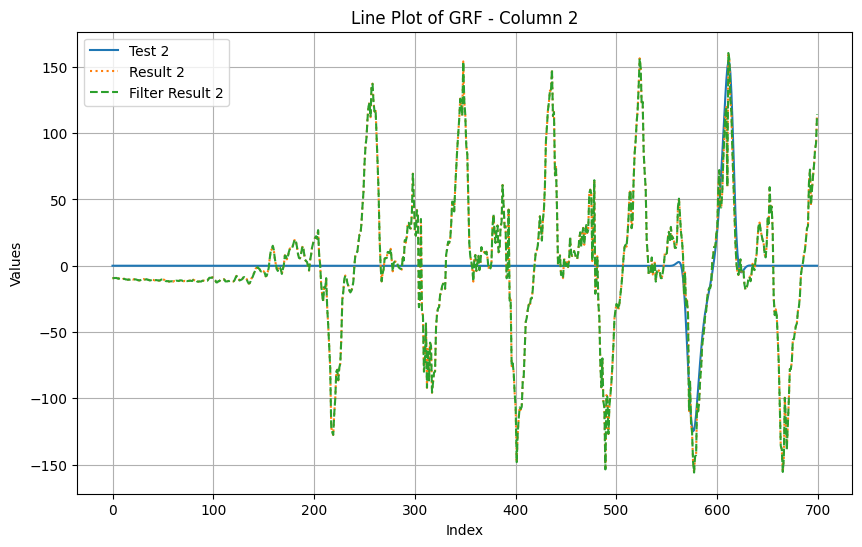

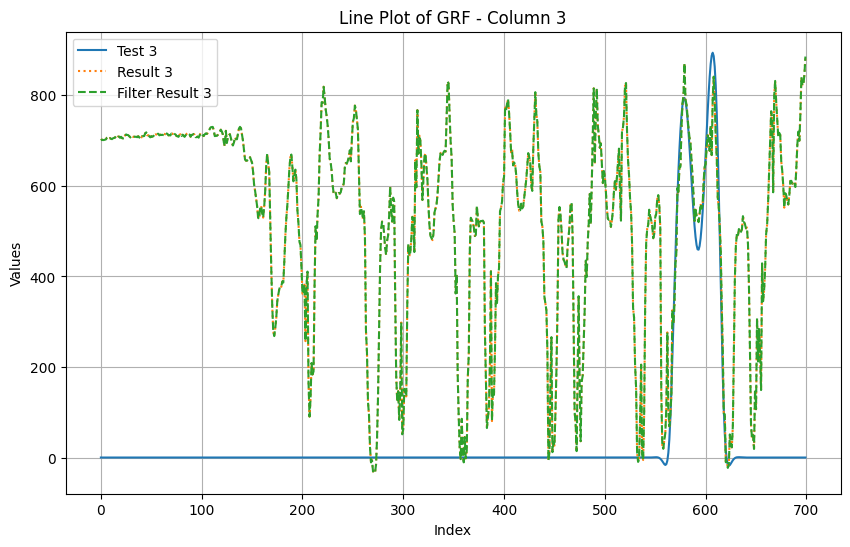

In [21]:
# Assuming y_test and predictions are already defined and are 2D NumPy arrays

min_window = 0
max_window = 700

# Loop over the number of columns
for i in range(y_test.shape[1]):
    plt.figure(figsize=(10, 6))  # Create a new figure for each column
    
    # Plot the test data
    plt.plot(y_test.iloc[min_window:max_window, i], label=f'Test {i+1}')  # Original test data
    
    # Plot the predictions
    plt.plot(predictions[min_window:max_window, i], label=f'Result {i+1}', linestyle=':')  # Predictions
    
    # Optional: Uncomment the next line if you have filtered predictions
    plt.plot(predictions_filtered[min_window:max_window, i], label=f'Filter Result {i+1}', linestyle='--')  # Filtered predictions
    
    # Adding titles and labels
    plt.title(f'Line Plot of GRF - Column {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    # plt.yscale('log')  # Optional: Use logarithmic scale for better visibility of small values
    
    plt.show()  # Show the figure for the current column

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


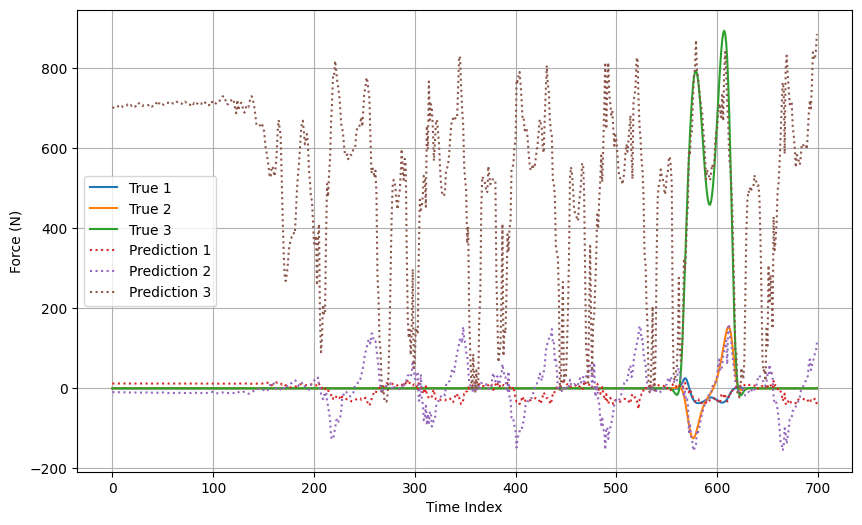

In [22]:
# Plotting the DataFrame
plt.figure(figsize=(10, 6))

for i in range(y_test.shape[1]):  # Loop over the number of columns
    plt.plot(y_test.iloc[min_window:max_window, i], label=f'True {i+1}')  # Use marker for visibility

# Plot each column as a separate line
for i in range(predictions.shape[1]):  # Loop over the number of columns
    # plt.plot(predictions[min_window:max_window, i], label=f'Result {i+1}', linestyle=':')  # Use marker for visibility
    plt.plot(predictions_filtered[min_window:max_window, i], label=f'Prediction {i+1}', linestyle=':')  # Use marker for visibility

# Adding titles and labels
# plt.title('Line Plot of GRF')
plt.xlabel('Time Index')
plt.ylabel('Force (N)')
plt.legend()
plt.grid()
# plt.yscale('log')  # Optional: Use logarithmic scale for better visibility of small values
plt.savefig(os.path.join(results_dir,f'prediction_results_01_l_comf.eps'), format='eps')  # Save as EPS
plt.show()

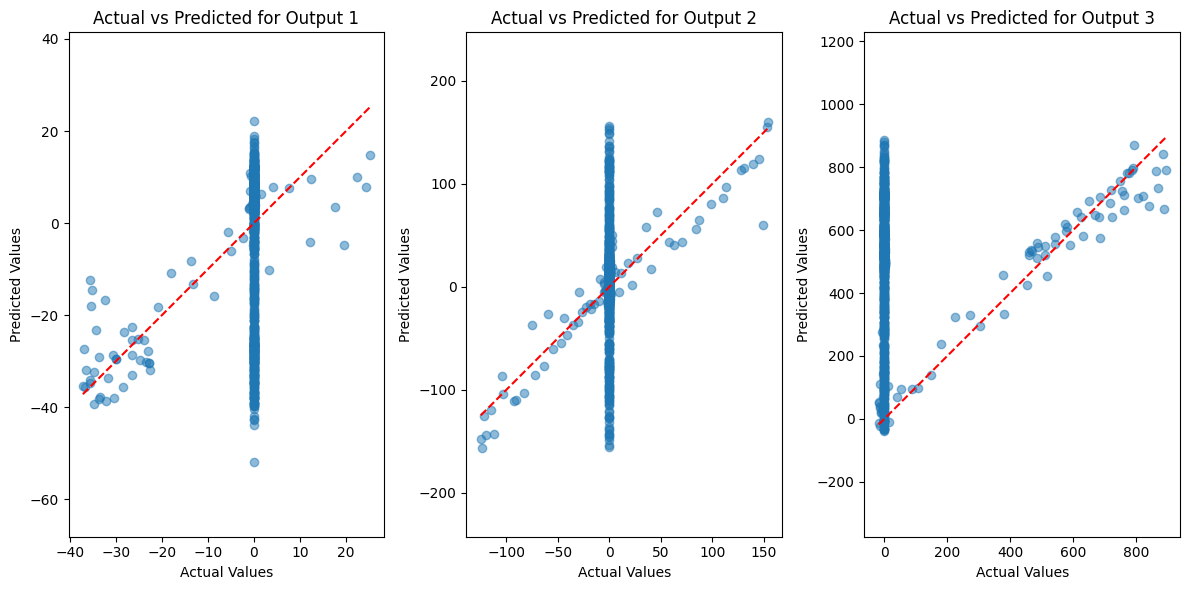

In [23]:
# Create a figure
plt.figure(figsize=(12, 6))
actual_values = y_test
predicted_values = predictions

# Plot actual vs predicted for each output (x, y, z)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(actual_values.iloc[:, i], predicted_values[:, i], alpha=0.5)
    plt.plot([actual_values.iloc[:, i].min(), actual_values.iloc[:, i].max()],
             [actual_values.iloc[:, i].min(), actual_values.iloc[:, i].max()], 'r--')  # Diagonal line
    plt.title(f'Actual vs Predicted for Output {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.axis('equal')

plt.tight_layout()
plt.show()